In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from copy import copy
from keras.layers import LSTM
from keras import optimizers as opt

import mbspbs10pc.model as mbs_model
from mbspbs10pc import read_activations, utils
reload(mbs_model)
reload(read_activations)
reload(utils);

# Load data

In [4]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timestamp_seq, _ = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timestamp_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False, random_state0=42, random_state1=420)

In [5]:
# x = tr_set[0][0]
# t = tr_set[0][1].squeeze()

# Load model

In [6]:
model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=2774,
                              embedding_size=50,
                              recurrent_units=32,
                              dense_units=32,
                              bidirectional=True,
                              LSTMLayer=LSTM)

model.load_weights('../../tmp/auc_879/output_weights.h5')

# Visualize the attention weights

In [7]:
dataset = copy(ts_set)

alpha = read_activations.get_activations(model, dataset[0], print_shape_only=True, layer_name='tsg_attention')[0]
omega = read_activations.get_activations(model, dataset[0], print_shape_only=True, layer_name='contribution')[0]

----- activations -----
(4698, 250, 64)
----- activations -----
(4698, 250, 64)


In [8]:
W_fc = model.get_layer(name='fc').get_weights()[0]
W_out = model.get_layer(name='fc_output').get_weights()[0]
W = W_fc.dot(W_out)  # 50 x 1
We = model.get_layer(name='mbs_embedding').get_weights()[0]  # 2774 x 50
w = We[dataset[0][0]].dot(W).squeeze()  # 6341 x 445
print(w.shape)

(4698, 250)


In [9]:
# avg_alpha = np.mean(alpha, axis=-1).squeeze()
avg_omega = np.mean(omega, axis=-1).squeeze()
avg_omega.shape

(4698, 250)

In [10]:
c = w * avg_omega
print(c.shape)

(4698, 250)


In [11]:
neg = np.where(dataset[1] == 0)[0]
pos = np.where(dataset[1] == 1)[0]

<IPython.core.display.Javascript object>


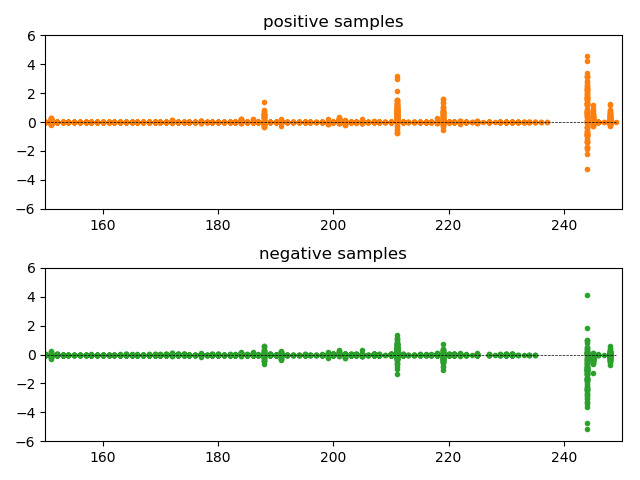

In [18]:
def zero_to_nan(row, eps=1e-3):
    return [float('nan') if np.abs(x)<eps else x for x in row]

xaxis = np.arange(avg_omega.shape[1])

plt.figure()
plt.subplot(2,1,1)
for i in pos[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C1')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('positive samples')

plt.subplot(2,1,2)
for i in neg[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C2')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('negative samples')

plt.tight_layout();

# Embedding viz

In [13]:
X = read_activations.get_activations(model, dataset[0], print_shape_only=True, layer_name='pooling')[0]

----- activations -----
(4698, 50)


In [14]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

X_r = PCA(n_components=3).fit_transform(X)

<IPython.core.display.Javascript object>


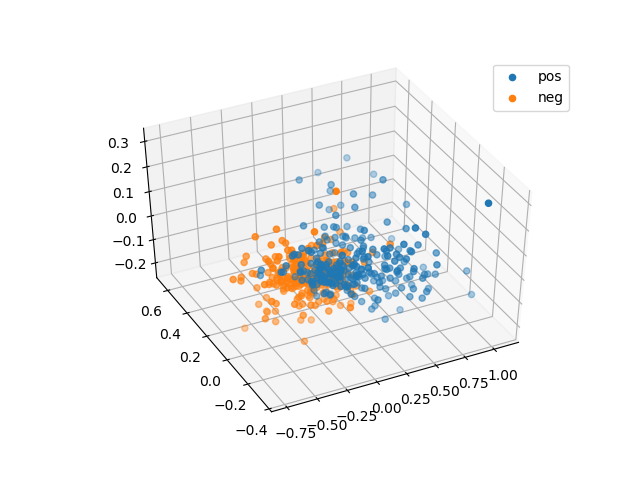

In [16]:
MAX = 250

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_r[pos[:MAX], 0], X_r[pos[:MAX], 1], X_r[pos[:MAX], 2], c='C0', label='pos')
ax.scatter(X_r[neg[:MAX], 0], X_r[neg[:MAX], 1], X_r[pos[:MAX], 2], c='C1', label='neg')
plt.legend();